c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


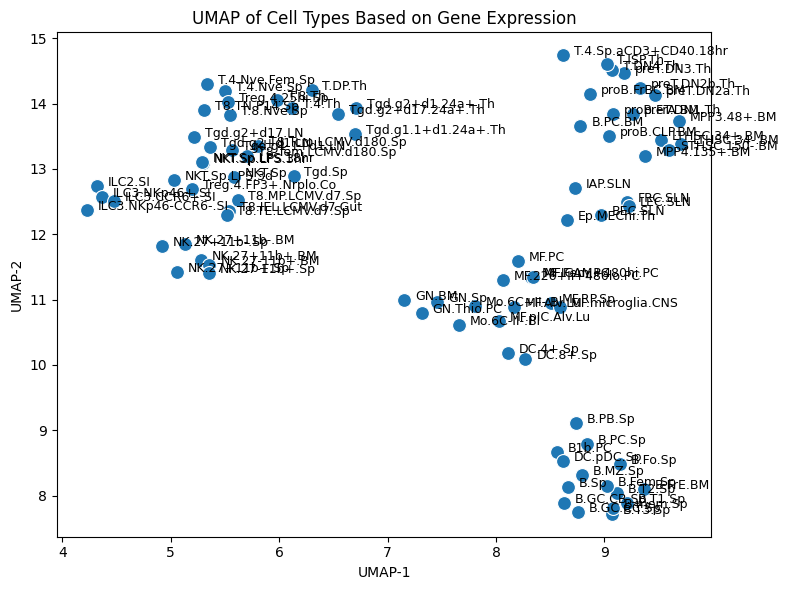

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

RNA_seq_path=r"C:\Users\helen\Downloads\datasets\mmc2.csv"
RNA_seq=pd.read_csv(RNA_seq_path,index_col=0)
RNA_seq_T=RNA_seq.T

RNA_seq_log = np.log1p(RNA_seq_T)  

scaler = StandardScaler()
RNA_seq_scaled = scaler.fit_transform(RNA_seq_log)

reducer = umap.UMAP(random_state=42)
umap_RNA_prep= reducer.fit_transform(RNA_seq_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_RNA_prep[:, 0], y=umap_RNA_prep[:, 1], s=100)


for i, label in enumerate(RNA_seq_T.index):
    plt.text(umap_RNA_prep[i, 0]+0.1, umap_RNA_prep[i, 1], label, fontsize=9)

plt.title("UMAP of Cell Types Based on Gene Expression")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

Now that we have our UMAP we will perform and compare the elbow and silhouette method to determine the optimal amount of clusters for kmeans clustering

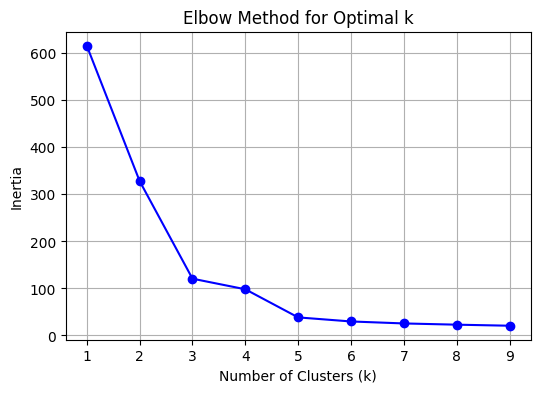

In [13]:
#elbow method to determine amount of clusters

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(umap_RNA_prep)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

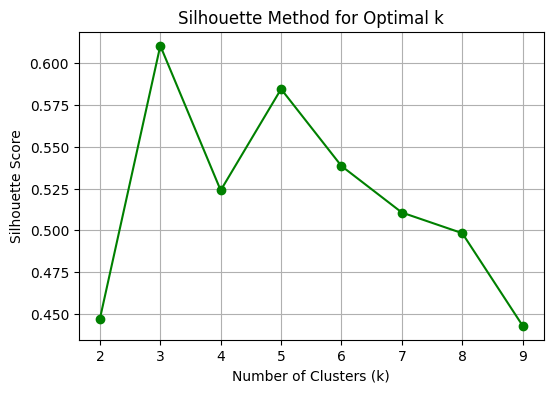

In [14]:
#test silhouette sore for kmeans clusterin
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 10):  # must be ≥2
    kmeans = KMeans(n_clusters=k, random_state=42).fit(umap_RNA_prep)
    labels = kmeans.labels_
    score = silhouette_score(umap_RNA_prep, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()

-> 3 and 5 both seem to be a good number of clusters, as they both show elbows in the elbow method and have local peaks in their silhouette score. This might signify that cells can be divided into 3 main groups that can be further divided into 5 subgroups

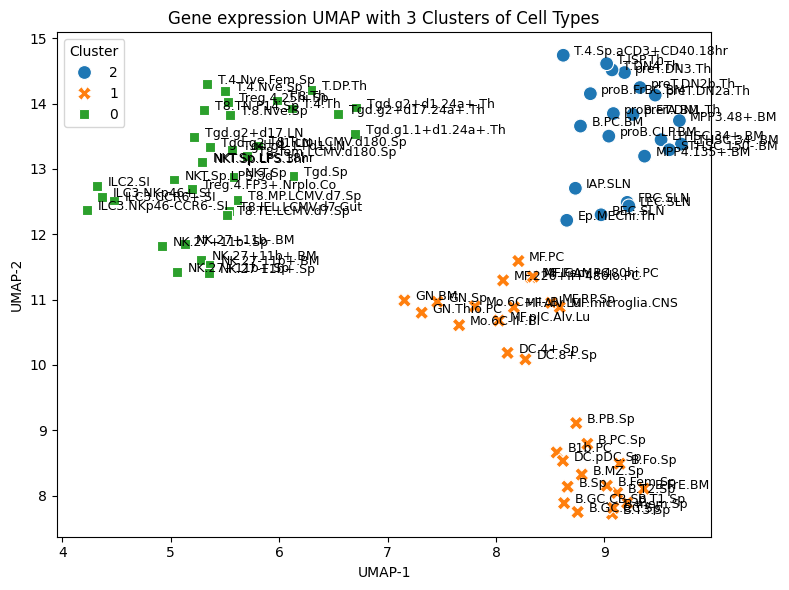

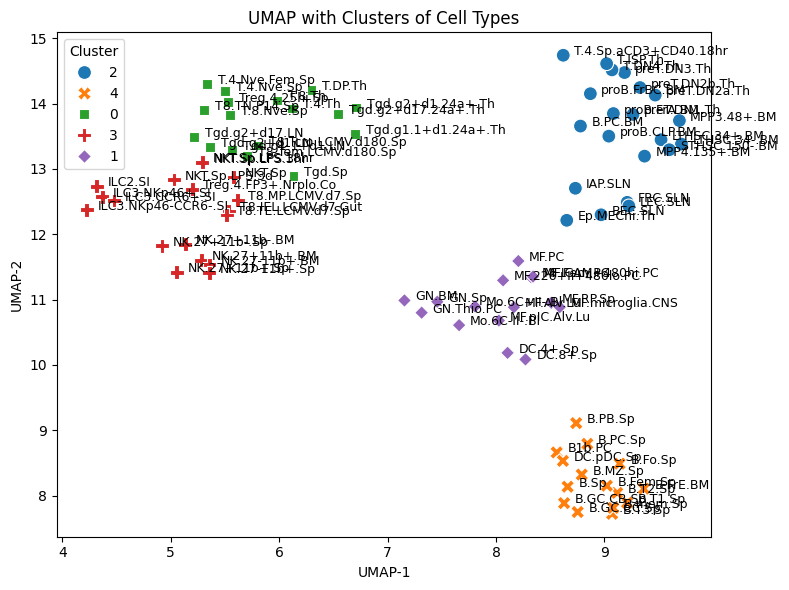

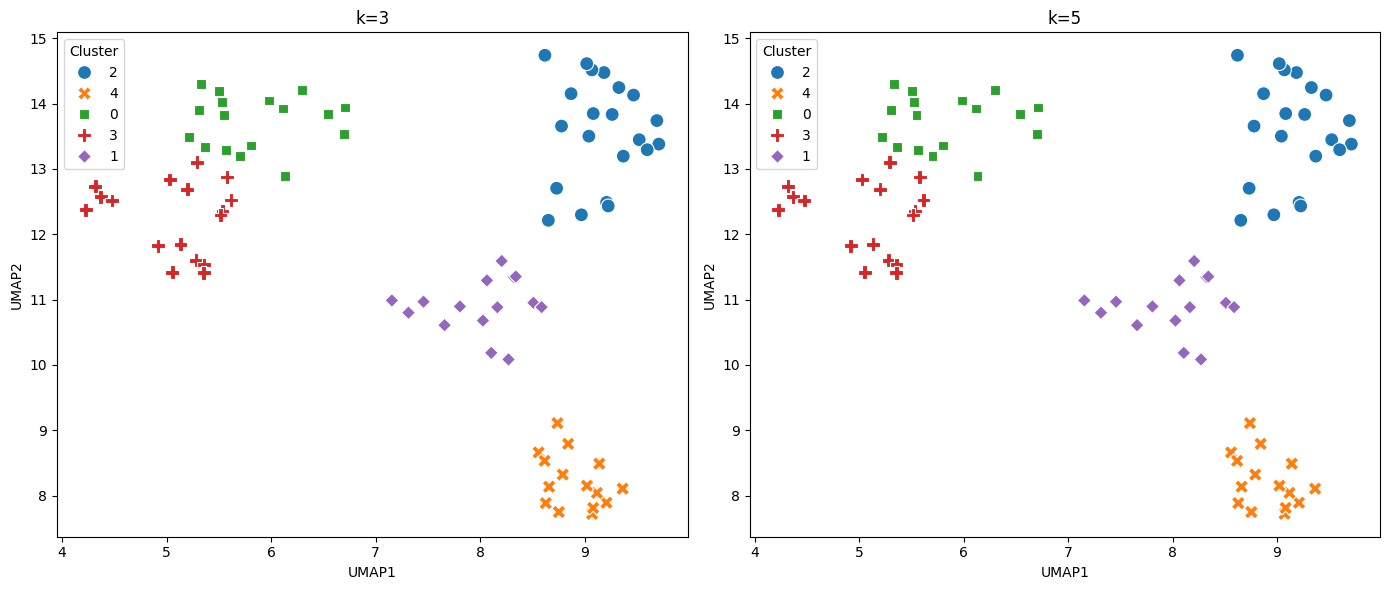

In [ ]:
from sklearn.cluster import KMeans

#kmeans with 3 clusters
kmeans3 = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans3.fit_predict(umap_RNA_prep)

umap_RNA_seq = pd.DataFrame(umap_RNA_prep, columns=["UMAP1", "UMAP2"])
umap_RNA_seq["CellType"] = RNA_seq_T.index
umap_RNA_seq["Cluster"] = cluster_labels.astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_RNA_seq, x="UMAP1", y="UMAP2", hue="Cluster", style="Cluster", s=100, palette="tab10")

for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["CellType"], fontsize=9)

plt.title("Gene expression UMAP with 3 Clusters of Cell Types")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


# kmeans with 5 clusters
kmeans5 = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans5.fit_predict(umap_RNA_prep)

umap_RNA_seq = pd.DataFrame(umap_RNA_prep, columns=["UMAP1", "UMAP2"])
umap_RNA_seq["CellType"] = RNA_seq_T.index
umap_RNA_seq["Cluster"] = cluster_labels.astype(str)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_RNA_seq, x="UMAP1", y="UMAP2", hue="Cluster", style="Cluster", s=100, palette="tab10")

for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row["CellType"], fontsize=9)

plt.title("UMAP with Clusters of Cell Types")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()




now we will perform leiden clustering to see how it compares

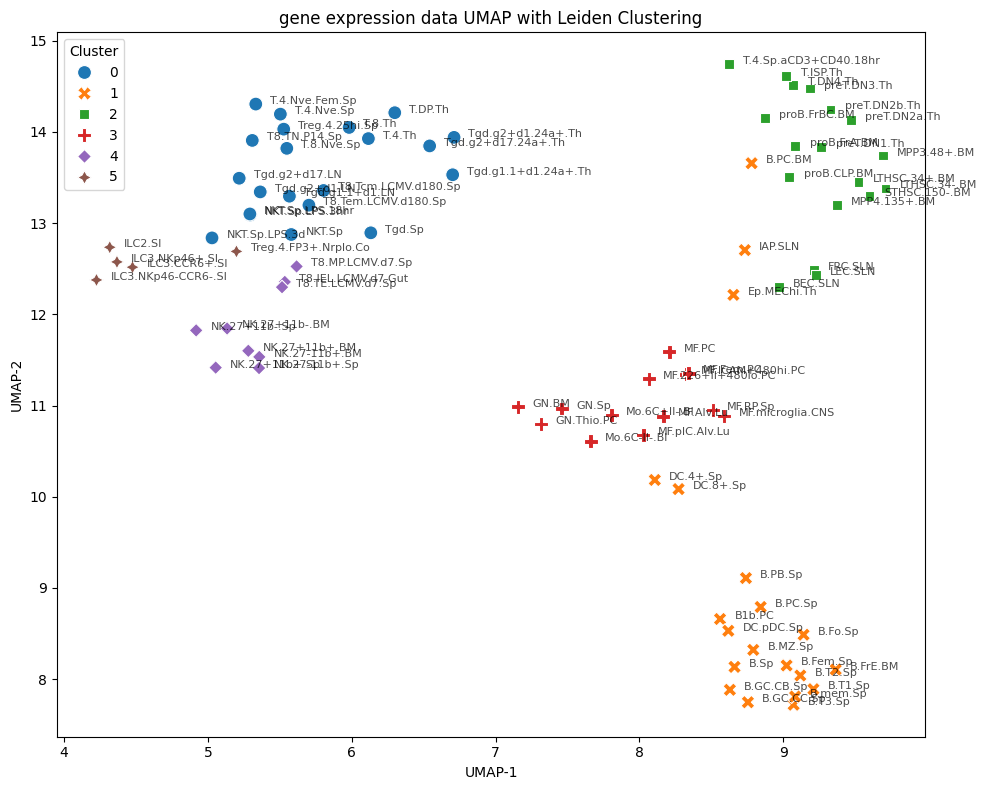

In [24]:
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

umap_RNA_seq = pd.DataFrame(umap_RNA_prep, columns=["UMAP1", "UMAP2"], index=RNA_seq_T.index)
adata = ad.AnnData(X=RNA_seq_T.values)
adata.obs_names = RNA_seq_T.index
adata.obsm["X_umap"] = umap_RNA_prep

sc.pp.neighbors(adata, use_rep="X", n_neighbors=10, random_state=42)
sc.tl.leiden(adata, resolution=1.0)

umap_RNA_seq["Leiden_Cluster"] = adata.obs["leiden"].values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_RNA_seq, x="UMAP1", y="UMAP2",
    hue="Leiden_Cluster", style="Leiden_Cluster",
    s=100, palette="tab10"
)
for i, row in umap_RNA_seq.iterrows():
    plt.text(row["UMAP1"] + 0.1, row["UMAP2"], row.name, fontsize=8, alpha=0.7)

plt.title("gene expression data UMAP with Leiden Clustering")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


now we will compare clustering via umap and kmeans

In [26]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

kmeans5_labels = kmeans5.fit_predict(umap_embedding)
umap_RNA_seq["KMeans_Cluster"] = kmeans5_labels.astype(str)

ari = adjusted_rand_score(umap_RNA_seq["Leiden_Cluster"], umap_RNA_seq["KMeans_Cluster"])
nmi = normalized_mutual_info_score(umap_RNA_seq["Leiden_Cluster"], umap_RNA_seq["KMeans_Cluster"])

print(f"Adjusted Rand Index (KMeans vs. Leiden): {ari:.3f}")
print(f"Normalized Mutual Information (KMeans vs. Leiden): {nmi:.3f}")

Adjusted Rand Index (KMeans vs. Leiden): 0.706
Normalized Mutual Information (KMeans vs. Leiden): 0.796
